In [2]:
import cv2
import numpy as np
import os
import glob
import pandas as pd

# Innere Ecken (Anzahl Schnittpunkte, nicht Felder!)
CHECKERBOARD = (3, 6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objpoints, imgpoints = [], []

square_size = 20.0  # mm
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size
#DateFrame mit Spalten definieren
df = []
df = pd.DataFrame(columns=["path", "img", "translation", "rotation", "points"])
patterns = []
# --- Pfade korrekt globs’en (hier rekursiv .jpg/.png) ---
base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung"
patterns = [os.path.join(base, "**", "*.jpg"),
            os.path.join(base, "**", "*.jpeg"),
            os.path.join(base, "**", "*.png")]
images = []
for pat in patterns:
    images.extend(glob.glob(pat, recursive=True))
print(f"{len(images)} Bilddateien gefunden.")

valid_size = None
valid_paths = []  # Liste für die Bilder, die tatsächlich Ecken liefern

for path in images:
    img = cv2.imread(path)  # BGR laden
    if img is None:
        print(f"Überspringe (nicht lesbar): {path}")
        continue

    # Grünkanal nehmen, um roten Laser zu minimieren
    b, g, r = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(g)

    # Ecken suchen
    ret, corners = cv2.findChessboardCorners(
        gray, CHECKERBOARD,
        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE
    )
    print(ret, "versuch:", path)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        valid_size = gray.shape[::-1]  # (width, height)
        valid_paths.append(path)       # Nur die „guten“ Bilder merken

# Kalibrieren
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, valid_size, None, None
)

print("Camera matrix:\n", mtx)
print(f"Es konnten {len(imgpoints)} von {len(images)} Bildern genutzt werden.")

# Jetzt DataFrame befüllen
rows = []
for path, rvec, tvec, corners in zip(valid_paths, rvecs, tvecs, imgpoints):
    rows.append({
        "path": path,
        "translation": tvec,
        "rotation": rvec,
        "points": None,
        "shape": valid_size
    })

df = pd.DataFrame(rows)



print("Camera matrix:\n", mtx)
print("Es konnten ", len(imgpoints), " von ", len(images), " Bildern genutzt werden.")
print("Translationsvektor: ", tvecs[-1],"\n", "Rotationsvektor: ", rvecs[-1])


30 Bilddateien gefunden.
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\10.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\09.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\08.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\07.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\06.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\05.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\04.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\02.jpg
True versuch: G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\03.jpg
True versuch: G:\Meine Ablage\

10 Bilddateien gefunden.
01.jp hat 0 iterationen gebraucht
02.jp hat 0 iterationen gebraucht
03.jp hat 0 iterationen gebraucht
05.jp hat 2 iterationen gebraucht
08.jp hat 2 iterationen gebraucht
04.jp hat 0 iterationen gebraucht
06.jp hat 0 iterationen gebraucht
10.jp hat 2 iterationen gebraucht
09.jp hat 1 iterationen gebraucht


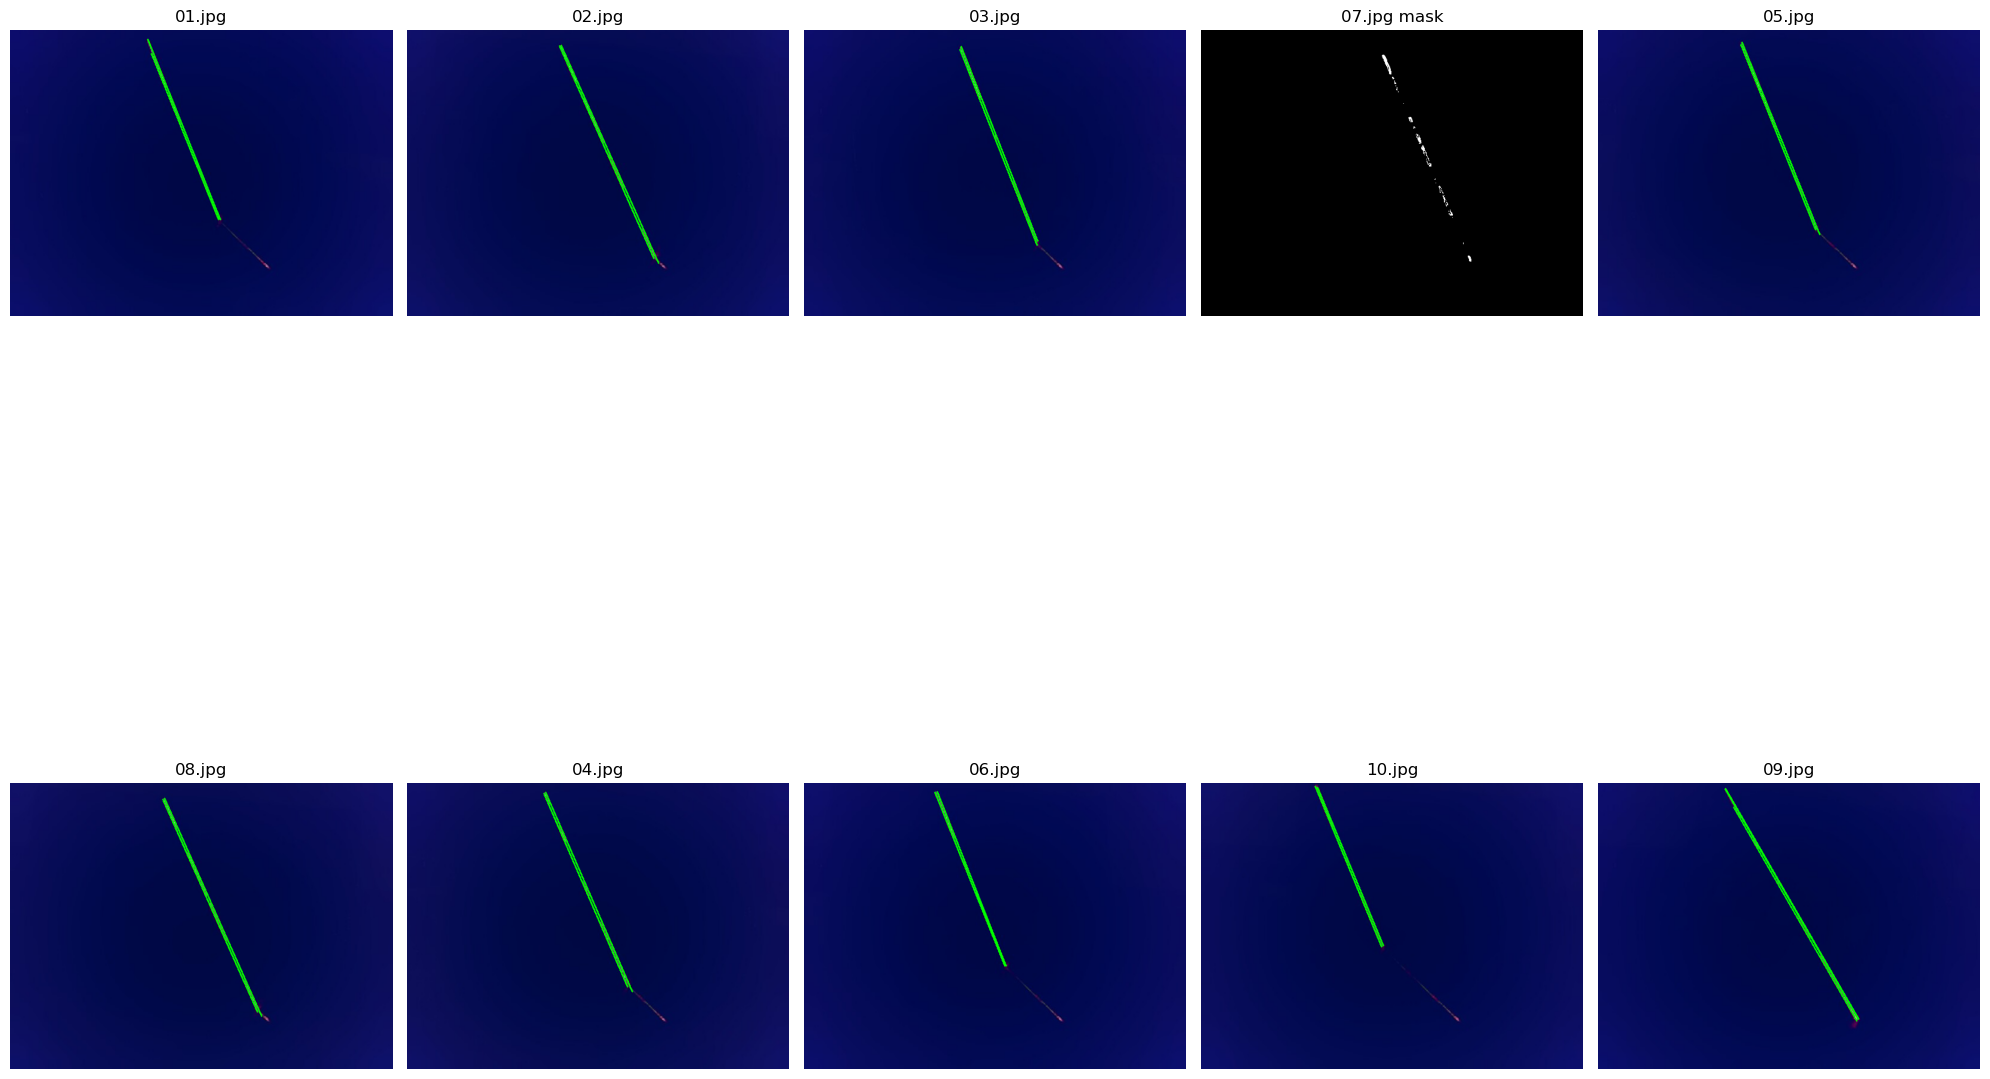

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.close('all')
%matplotlib inline
base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\laser_dark"
patterns = [os.path.join(base, "**", "*.jpg"),
            os.path.join(base, "**", "*.jpeg"),
            os.path.join(base, "**", "*.png")]
images = []
for pat in patterns:
    images.extend(glob.glob(pat, recursive=True))
print(f"{len(images)} Bilddateien gefunden.")



rows, cols = 2,5
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Größe anpassen

for ax, path in zip(axes.ravel(), images):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 80, 50])
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    lower_red2 = np.array([170, 80, 50])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask1, mask2)

    # Magenta/Pink in HSV (OpenCV: H 0..180)
    lower_magenta = np.array([113, 43, 52])
    upper_magenta = np.array([165, 188, 203])

    mask01 = cv2.inRange(hsv, lower_magenta, upper_magenta)
    mask = cv2.bitwise_or(mask_red, mask01)

    edges = cv2.Canny(mask, 50, 150, apertureSize=7)
    #liniensegmente mit HoughLinesP ermitteln
    linesP = cv2.HoughLinesP(edges, 1, np.pi/360, 100, minLineLength=10, maxLineGap=200)

    img_houghP = img.copy()
    #liniensegmente auf dem ursprungsbild visualisieren
    if linesP is not None:
        thresh = 100
        i=0
        while len(linesP) != 2:
            i = i+1
            if len(linesP) < 2:
                thresh = thresh - 1
            elif len(linesP) > 2:
                thresh = thresh + 1
            linesP = cv2.HoughLinesP(edges, 1, np.pi/360, thresh, minLineLength=200, maxLineGap=1000)
        print(f"{path[-6:-1]} hat {i} iterationen gebraucht")
        points = [tuple(pt) for pt in linesP[:,0].reshape(-1, 2)]
        df.loc[df["path"] == path, "points"] = [points]
        for (x1, y1, x2, y2) in linesP[:,0]:
            cv2.line(img_houghP, (x1, y1), (x2, y2), (0, 255, 0), 2)

        ax.imshow(cv2.cvtColor(img_houghP, cv2.COLOR_BGR2RGB))
        ax.set_title(f"{path.split(os.sep)[-1]}")
    else:
        ax.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax.set_title(f"{path.split(os.sep)[-1]} mask")  # nur Dateiname


    ax.axis("off")

# Falls weniger Bilder als Plätze im Grid
for ax in axes.ravel()[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [5]:
import numpy as np

def midpoint_to_line_distance(x1, y1, x2, y2, u1, v1, u2, v2):
    """
    Abstand vom Mittelpunkt des Segments (x1,y1)-(x2,y2)
    zur unendlichen Geraden durch (u1,v1)-(u2,v2).
    """
    # Mittelpunkt des ersten Segments
    M = np.array([(x1+x2)/2, (y1+y2)/2], dtype=float)
    Q1 = np.array([u1, v1], dtype=float)
    Q2 = np.array([u2, v2], dtype=float)
    d = Q2 - Q1

    if np.allclose(d, 0):  # degeneriertes Segment
        return np.linalg.norm(M - Q1)

    # Kreuzprodukt und Norm
    num = abs(np.cross(M - Q1, d))
    den = np.linalg.norm(d)
    return num / den


threshold = 1  # dein Abstandslimit in Pixeln (z.B.)

rows_to_drop = []  # Index-Liste der rauszufilternden Zeilen

for idx, row in df.iterrows():
    points = row["points"]
    if points is None or len(points) < 4:
        continue  # keine gültigen Linien

    # Annahme: genau zwei Liniensegmente, also 2×(x1,y1,x2,y2)
    (x1, y1, x2, y2), (u1, v1, u2, v2) = np.array(row["points"]).reshape(-1, 4)

    dist = midpoint_to_line_distance(x1, y1, x2, y2, u1, v1, u2, v2)

    if dist < threshold:
        print(f"Lösche {row['path']} (Abstand {dist:.2f} < {threshold})")
        rows_to_drop.append(idx)

# Ganze Zeilen löschen
df = df.drop(index=rows_to_drop).reset_index(drop=True)
print(rows_to_drop)
points_right = []
points_left = []
#hier die punkte einteilen in links und rechts
# Spalten sicherstellen
if "points_left" not in df.columns:
    df["points_left"] = None
if "points_right" not in df.columns:
    df["points_right"] = None

# Spalten leeren (alte Werte entfernen)
df["points_left"] = None
df["points_right"] = None


for idx, row in df.iterrows():
    points = row["points"]
    if points is None or len(points) < 4:
        continue  # keine gültigen Linien

    # Annahme: genau zwei Liniensegmente -> 2x(x1,y1,x2,y2)
    (x1, y1, x2, y2), (u1, v1, u2, v2) = np.array(points).reshape(-1, 4)

    sx1 = schnittpunkt_xAchse(x1, y1, x2, y2)
    sx2 = schnittpunkt_xAchse(u1, v1, u2, v2)

    if sx1 <= sx2:
        points_left = [(x1, y1), (x2, y2)]
        points_right = [(u1, v1), (u2, v2)]
    else:
        points_left = [(u1, v1), (u2, v2)]
        points_right = [(x1, y1), (x2, y2)]
    # Spalten sicherstellen

    # ins DataFrame schreiben
    df.at[idx, "points_left"] = points_left
    df.at[idx, "points_right"] = points_right



[]


Ab hier wirds knackig:
1. Pixelkoordinaten u,v in pixelvektor packen [u, v, 1] und in die bereits existierende Pixel to CameraVector() geben (benötigt K un sonst nichts?)
    -ich glaube dierser Vektor gibt die richtung des Kamerastrahls an. Man kann davon ausgehen, dass die kamera der Usprung ist VORERST
2. herausfinden wo dieser Strahl das Checkerboard schneidet. Das Checkerboard kann als Ebene mit den informationen aus trvec und rotvec dargestellt werden
3. punkte sammeln und plotten dann reichts für heute

In [6]:
def pixel_to_cameraVector(u, v, K):
    pixelVector = np.array([u, v, 1])
    cameraVector = np.linalg.inv(K) @ (pixelVector )
    cameraVector = cameraVector / np.linalg.norm(cameraVector)
    return cameraVector
def get_normal_Checkerboard(rvec):
    #Normalenvektor des checkerboards ist aus R transformierte Z-Achse
    R, _ = cv2.Rodrigues(rvec)
    z= np.array([0, 0, 1])
    normal = R @ z
    return normal / np.linalg.norm(normal)
def get_intersection(cameraVector, tvec, normal):
    #Vereinfacht, da ursprung [0,0,0]
    lam = (normal @ tvec) / (normal @ cameraVector)
    P = lam * cameraVector
    return P

row = df.iloc[-1]            # erste Zeile
points = row["points"]
print(row["path"])
# Liste der Punkte
u, v = points[0]            # erstes Tupel (x1, y1)
#tvec und rvec extrahieren
tvec = (row["translation"].reshape(3))
rvec = (row["rotation"].reshape(3))
cameraVector = pixel_to_cameraVector(u, v, mtx)
normal = get_normal_Checkerboard(rvec)

p = get_intersection(cameraVector, tvec, normal)
print(p)

G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\checkerboard_light\03.jpg


TypeError: 'NoneType' object is not subscriptable

In [7]:
Plane_pointsR = []
Plane_pointsL = []

for idx, row in df.iterrows():
    for pts in [row["points_left"]][0:5]:
        if pts is None:
            continue
        for (u, v) in pts:
            tvec = row["translation"].reshape(3)
            rvec = row["rotation"].reshape(3)

            cam_vec = pixel_to_cameraVector(u, v, mtx)
            normal = get_normal_Checkerboard(rvec)
            P = get_intersection(cam_vec, tvec, normal)

            Plane_pointsR.append(P)
    for pts in [row["points_right"]][0:5]:
        if pts is None:
            continue
        for (u, v) in pts:
            tvec = row["translation"].reshape(3)
            rvec = row["rotation"].reshape(3)

            cam_vec = pixel_to_cameraVector(u, v, mtx)
            normal = get_normal_Checkerboard(rvec)
            P = get_intersection(cam_vec, tvec, normal)

            Plane_pointsL.append(P)



In [8]:

scanned_PointsR = np.asarray(Plane_pointsR, dtype=float).reshape(-1, 3)
scanned_PointsL = np.asarray(Plane_pointsL, dtype=float).reshape(-1, 3)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#Plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1,1,1])
def set_axes_equal(ax):
    '''Gleiche Skalierung für alle 3 Achsen'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range, x_middle + max_range])
    ax.set_ylim3d([y_middle - max_range, y_middle + max_range])
    ax.set_zlim3d([z_middle - max_range, z_middle + max_range])

ax.scatter(scanned_PointsR[:, 0], scanned_PointsR[:, 1], scanned_PointsR[:, 2], c='b', s=5)
ax.scatter(scanned_PointsL[:, 0], scanned_PointsL[:, 1], scanned_PointsL[:, 2], c='r', s=5)

set_axes_equal(ax)
#Ausrichtung wie in solidworks/3d kamerakonventionen
ax.view_init(elev=90, azim=-90)
# Axes labels and legend

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

<IPython.core.display.Javascript object>

In [9]:
import os
base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte"

# Zielpfad im Projektordner (z. B. neben deinem Notebook)
save_path = os.path.join(base, "calibration_results_thinlaser.pkl")

# DataFrame speichern
df.to_pickle(save_path)

print(f"✅ DataFrame erfolgreich gespeichert unter:\n{save_path}")


✅ DataFrame erfolgreich gespeichert unter:
G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl


In [10]:
import os
import pickle

save_path = os.path.join(base, "calibration_results_thinlaser.pkl")

data = {
    "df": df,
    "mtx": mtx,
    "dist": dist
}

with open(save_path, "wb") as f:
    pickle.dump(data, f)

print(f"✅ Alles gespeichert unter:\n{save_path}")


✅ Alles gespeichert unter:
G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl


In [11]:
import cv2
img = cv2.imread(r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung\laser_dark\01.jpg")

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === 1. Bild laden und in HSV umwandeln ===
#img = cv2.imread("01.jpg")
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Für K-Means vorbereiten
data = hsv.reshape((-1, 3))
data = np.float32(data)

# === 2. K-Means Clustering (2 Klassen) ===
K = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
_, labels, centers = cv2.kmeans(
    data, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

# Ergebnisse rekonstruieren
centers = np.uint8(centers)
segmented = centers[labels.flatten()].reshape(hsv.shape)
labels_img = labels.reshape(hsv.shape[:2])

# === 3. Pixel nach Cluster trennen ===
cluster_counts = [np.sum(labels == i) for i in range(K)]
laser_cluster = int(np.argmin(cluster_counts))  # Der kleinere Cluster = Laser
background_cluster = int(np.argmax(cluster_counts))

# HSV-Werte der Cluster speichern
laser_hsv = data[labels.flatten() == laser_cluster]
background_hsv = data[labels.flatten() == background_cluster]

np.save("laser_hsv.npy", laser_hsv)
np.save("background_hsv.npy", background_hsv)

print(f"Laser-Cluster: {laser_hsv.shape[0]} Pixel")
print(f"Hintergrund-Cluster: {background_hsv.shape[0]} Pixel")
print("HSV-Werte gespeichert unter laser_hsv.npy & background_hsv.npy")

# === 4. Matplotlib-Visualisierung ===

# (a) Cluster-Farbbild anzeigen
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_HSV2RGB))
plt.title("Cluster-Farbbild (2 Klassen)")
plt.axis("off")

# (b) HSV-Verteilung beider Cluster plotten
plt.subplot(1, 2, 2)
plt.scatter(
    background_hsv[:, 0], background_hsv[:, 1],
    s=1, color="blue", alpha=0.3, label="Hintergrund"
)
plt.scatter(
    laser_hsv[:, 0], laser_hsv[:, 1],
    s=2, color="red", alpha=0.7, label="Laser"
)
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("HSV-Verteilung (H vs S)")
plt.legend()
plt.tight_layout()
plt.show()


Laser-Cluster: 941 Pixel
Hintergrund-Cluster: 306259 Pixel
HSV-Werte gespeichert unter laser_hsv.npy & background_hsv.npy


<IPython.core.display.Javascript object>

C:\Users\janne\AppData\Local\Temp\ipykernel_3128\2548003621.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


In [13]:
print("h bereich:", max(laser_hsv[:,0]), min(laser_hsv[:,0]),)
print("s bereich;", max(laser_hsv[:,1]), min(laser_hsv[:,1]),)
print("v bereich: ", max(laser_hsv[:,2]), min(laser_hsv[:,2]),)
print(laser_hsv)

h bereich: 165.0 113.0
s bereich; 188.0 43.0
v bereich:  203.0 52.0
[[126. 165.  96.]
 [123. 175.  93.]
 [128. 163.  97.]
 ...
 [152. 156.  77.]
 [157. 127. 110.]
 [142. 165. 111.]]
